In [1]:
import pandas as pd
import pgaccess as pg
import seaborn as sns
import matplotlib.pyplot as plt

from plot_helpers import two_axes_plot

# Flights per city

In [2]:
cityFlights = pg.execute_query('''
SELECT
    origin_city_name,
    COUNT(*) AS flight_count
FROM flights
GROUP BY origin_city_name
ORDER BY flight_count DESC
''')
cityFlights

,origin_city_name,flight_count
0,"Chicago, IL",962032
1,"Atlanta, GA",785850
2,"New York, NY",599657
3,"Dallas/Fort Worth, TX",584688
4,"Denver, CO",552134
...,...,...
363,"Gustavus, AK",166
364,"Rota, TT",151
365,"King Salmon, AK",124
366,"Bullhead City, AZ",45


In [19]:
# Figure out when 'other' makes up 20% of the total
twentyPercent = cityFlights.flight_count.sum() / 3
for i in range(1, cityFlights.shape[0]):
    if cityFlights.iloc[-i:, 1].sum() > twentyPercent:
        print(cityFlights.shape[0] - i)
        break

29


The last 316 rows make up 20% of the total

In [28]:
cutoff = 25
top = cityFlights.iloc[:cutoff]
agg = pd.DataFrame({
    'origin_city_name': ['Other'],
    'flight_count': [cityFlights.iloc[cutoff:, 1].sum()]
})
simplified = pd.concat([top, agg])
simplified

,origin_city_name,flight_count
0,"Chicago, IL",962032
1,"Atlanta, GA",785850
2,"New York, NY",599657
3,"Dallas/Fort Worth, TX",584688
4,"Denver, CO",552134
5,"Charlotte, NC",501557
6,"Los Angeles, CA",500840
7,"Washington, DC",472958
8,"Houston, TX",472442
9,"Seattle, WA",379367


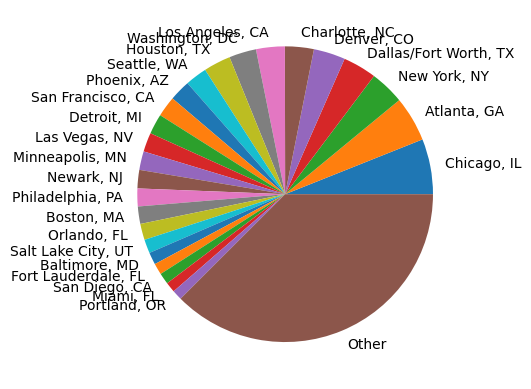

In [29]:
plt.pie(data=simplified, x='flight_count', labels='origin_city_name')
plt.show()

In [30]:
cityFlights.iloc[:10,1].sum() / cityFlights.flight_count.sum()

0.364873989835809

# Delays per hour

In [2]:
hourlyDelays = pg.execute_query('''
SELECT
    (dep_time / 100)::INT AS "hour",
    AVG(arr_delay) AS mean_delay,
    PERCENTILE_CONT(0.5) WITHIN GROUP(ORDER BY arr_delay) AS median_delay,
    COUNT(*) FILTER (WHERE arr_delay > 0) AS delay_count
FROM flights
GROUP BY "hour"
ORDER BY "hour" ASC
''')
hourlyDelays.dropna(inplace=True)
hourlyDelays

,hour,mean_delay,median_delay,delay_count
0,0.0,63.322059,20.0,34915
1,1.0,70.434770,14.0,19022
2,2.0,99.333298,47.0,6558
3,3.0,72.916650,5.0,2683
4,4.0,15.525011,-12.0,1888
5,5.0,-8.832101,-11.0,54875
6,6.0,-6.496676,-9.0,227710
7,7.0,-3.665501,-9.0,249700
8,8.0,-1.702555,-8.0,276561
9,9.0,0.298463,-8.0,252411


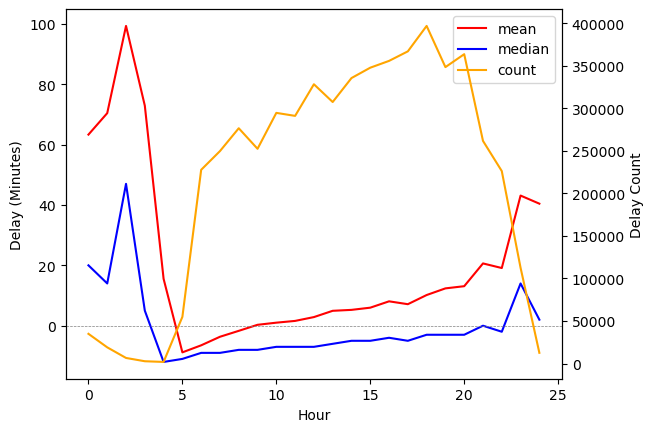

In [3]:
fig, ax = plt.subplots()
two_axes_plot(
    ax = ax,
    x = hourlyDelays.hour,
    y1 = hourlyDelays[['mean_delay', 'median_delay']].to_numpy(),
    y2 = hourlyDelays.delay_count,
    xlabel = 'Hour',
    ylabel1 = 'Delay (Minutes)',
    ylabel2 = 'Delay Count',
    colors = [['red', 'blue'], 'orange'],
    legend = ['mean', 'median', 'count']
)
ax.axhline(0, color='gray', linewidth=0.5, linestyle='--')
plt.show()

# Average route delay between top 10 cities

In [40]:
routeDelays = pg.execute_query('''
SELECT
    origin_city_name,
    dest_city_name,
    AVG(arr_delay) AS mean_delay
FROM flights
GROUP BY origin_city_name, dest_city_name
''')
routeDelays

,origin_city_name,dest_city_name,mean_delay
0,"Aberdeen, SD","Minneapolis, MN",7.537517
1,"Abilene, TX","Dallas/Fort Worth, TX",6.213963
2,"Adak Island, AK","Anchorage, AK",5.311558
3,"Aguadilla, PR","Fort Lauderdale, FL",2.567891
4,"Aguadilla, PR","Newark, NJ",21.226727
...,...,...,...
6468,"Yakutat, AK","Juneau, AK",-9.587234
6469,"Youngstown/Warren, OH","Sanford, FL",9.000000
6470,"Youngstown/Warren, OH","St. Petersburg, FL",141.000000
6471,"Yuma, AZ","Dallas/Fort Worth, TX",5.667692


In [48]:
# Any cities that aren't in the top 10 should be grouped
top10 = list(cityFlights.head(10).origin_city_name)
routeDelays.loc[~routeDelays.origin_city_name.isin(top10), 'origin_city_name'] = 'Other'
routeDelays.loc[~routeDelays.dest_city_name.isin(top10), 'dest_city_name'] = 'Other'
routeDelays

,origin_city_name,dest_city_name,mean_delay
0,Other,Other,7.537517
1,Other,"Dallas/Fort Worth, TX",6.213963
2,Other,Other,5.311558
3,Other,Other,2.567891
4,Other,Other,21.226727
...,...,...,...
6468,Other,Other,-9.587234
6469,Other,Other,9.000000
6470,Other,Other,141.000000
6471,Other,"Dallas/Fort Worth, TX",5.667692


In [50]:
groupedRouteDelays = routeDelays.groupby(['origin_city_name', 'dest_city_name']).mean()
groupedRouteDelays

mean_delay
origin_city_name dest_city_name                   
Atlanta, GA      Charlotte, NC            0.924427
                 Chicago, IL              5.291277
                 Dallas/Fort Worth, TX    5.982035
                 Denver, CO               3.850715
                 Houston, TX              3.988508
...                                            ...
Washington, DC   Houston, TX              4.185876
                 Los Angeles, CA         -3.331708
                 New York, NY             9.081313
                 Other                    8.535341
                 Seattle, WA             -3.610320

[111 rows x 1 columns]

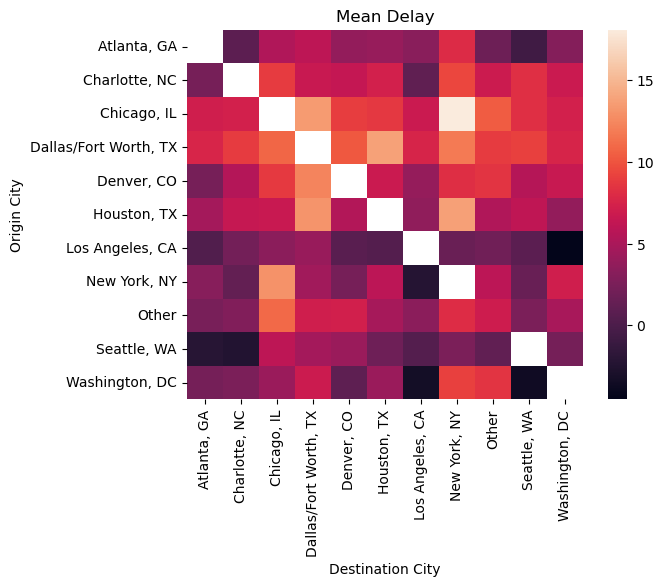

In [62]:
heatmap = groupedRouteDelays.unstack()

fig, ax = plt.subplots()
sns.heatmap(
    heatmap,
    ax = ax,
    xticklabels = heatmap.columns.get_level_values(1)
)
ax.set_ylabel('Origin City')
ax.set_xlabel('Destination City')
ax.set_title('Mean Delay')
plt.show()